In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from pathlib import Path
import cv2
import os
import warnings
import pandas as pd
from collections import deque


In [48]:
# hyperparameters
batch_size = 32
lr = 0.0001
imgSize = 150
epochs = 5
numTrainSamples = 1000  # Change later on
numValSamples = 100  # Change later on

normal       0.258111
pneumonia    0.741889
dtype: float64

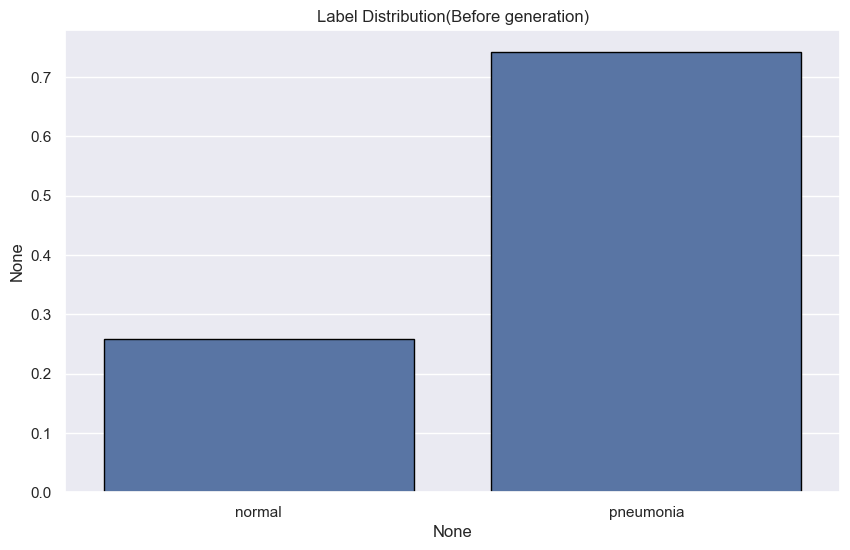

In [49]:
data_dir = Path("kaggle/input/pneumonia-xray-images")
train = data_dir / "train"
val = data_dir / "val"
test = data_dir / "test"

normal = train / "normal"
pneumonia = train / "opacity"


normalFreq = sum(1 for _ in normal.glob("*.jpeg"))
pneumoniaFreq = sum(1 for _ in pneumonia.glob("*.jpeg"))

numTrainSamples = normalFreq + pneumoniaFreq
numValSamples = sum(1 for _ in val.glob("**/*.jpeg"))

labels = pd.Series([*[0]*normalFreq, *[1]*pneumoniaFreq])

sns.set()
fig, ax = plt.subplots(1, figsize=(10,6))
vc = labels.value_counts(normalize=True, sort=False)
labels = pd.Series(vc.values, index=["normal", "pneumonia"])
# labels
count = sns.barplot(x=labels.index, y=labels, edgecolor="black", ax=ax)
count.set_title("Label Distribution(Before generation)")

plt.savefig("out/proportions-before-augmentation.jpg")
labels

In [50]:

# Data Augmentation
# Creating an ImageGenerator
data_gen = ImageDataGenerator(rescale=1./255,   # Rescale from 0-255 to 0-1
                                   rotation_range=30,  # rondomly rotate training iamges by 30
                                   width_shift_range=0.1,  # randomly shift images horizontally by 10% of width
                                   height_shift_range=0.1,   # randomly shift images horizontally by 10% of height
                                   zoom_range=0.2,  # Randomly zoom in/out 20% into image
                                   horizontal_flip=True)  # Randomly flip image horizontally


data_gen_test = ImageDataGenerator(rescale=1./255)

training_gen = data_gen.flow_from_directory(train, target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")
validation_gen = data_gen.flow_from_directory(val, target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")
test_datagen = data_gen_test.flow_from_directory(test, target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")
# # Visualizing the outputs of the generators

# fig, axs = plt.subplots(1,4, figsize=(10,3))
# fig.suptitle("Generated Training Images")
# generated = next(training_gen)
# images = generated[0]
# for i, ax in enumerate(axs):
#     ax.imshow(images[i])
#     ax.axis('off')
    
    
    


Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


0    0.25625
1    0.74375
dtype: float64

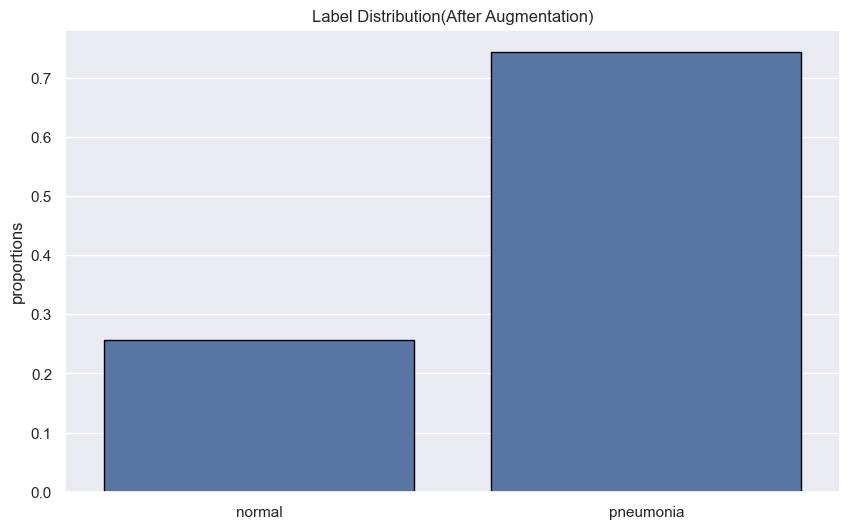

In [51]:

total = pd.Series([0,0])

for i in range(5):
    generated = next(training_gen)
    labels = np.array(generated[1]).astype(int) 
    total += np.array(pd.Series(labels).value_counts(normalize=True, sort=False).sort_values())
    
total /= 5
sns.set()
fig, ax = plt.subplots(1, figsize=(10,6))
ax.set_ylabel("proportions")
count = sns.barplot(x=["normal", "pneumonia"], y=total, edgecolor = "black", ax=ax)
count.set_title("Label Distribution(After Augmentation)")
plt.savefig("out/proportions-after-augmentation.jpg")
total

In [52]:
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , input_shape = (imgSize,imgSize,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 148, 148, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 74, 74, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 74, 74, 64)       

In [46]:
history = model.fit(training_gen,epochs = epochs , validation_data = validation_gen, steps_per_epoch=numTrainSamples//batch_size, validation_steps=numValSamples//batch_size)



Epoch 1/10
 29/131 [=====>........................] - ETA: 1:53 - loss: 0.2867 - accuracy: 0.8685

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_datagen, verbose=1)